# Steinkauz

## Notebook: avo_for_density

See the [Steinkauz repository](https://github.com/bjornrommel/steinkauz) for the code source.

In [1]:
# load project magics
try:
    %reload_ext steinkauz
except ModuleNotFoundError as msg:
    print(msg)
    print("steinkauz not installed?")

In [2]:
%steinkauz --option setup --prefile mypackages.tex --predir .

In [3]:
# import Python, IPython modules
import sys
import numpy as np
from functools import wraps
from IPython.display import display, Image, Javascript
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
import avo_for_density as ad

In [4]:
# define matplotlib in one of the following two alternatives: notebook or inline (preferrably with retina)
%matplotlib ipympl

In [5]:
# set default parameters
import matplotlib as mpl
# change to local matplotlibrc and edit the same parameters or set the rcParams below
### mpl.matplotlib_fname()                   # print location of matplotlibrc
mpl.rcParams['text.usetex'] = True           # use latex
### mpl.rcParams['ps.usedistiller'] = None   # 'ghostscript' or 'xpdf', but any difference?
mpl.rcParams['font.size'] = 11

In [6]:
# input toggle
%inputtoggle

Set the DPI and magnification of the screen output!

In [7]:
# request DPI
dpi_box = ipw.BoundedIntText(value=300, min=1, max=sys.maxsize, step=1, description='DPI')

# update DPI
def dpi_update(**kwargs):
    global dpi
    dpi = kwargs['dpi']

# interact with dpi box
@interact(dpi=dpi_box)
@wraps(dpi_update)
def func(**kwargs):
    # update dpi
    dpi_update(**kwargs)


# request magnification
mag_box = ipw.BoundedFloatText(description="magnification", value=0.5, step=0.01)

# update mag
def mag_update(**kwargs):
    global mag
    mag = kwargs['mag']

# interact with mag box
@interact(mag=mag_box)
@wraps(mag_update)
def func(**kwargs):
    # update magnification
    mag_update(**kwargs)


def button_action(*args):
    # do nothing but wake up Jupyter
    pass 
    
# click button
button =  ipw.Button(description = 'update', button_style = 'info', tooltip = 'update calculations and graphics')
display(button)
button.on_click(button_action)

interactive(children=(BoundedIntText(value=300, description='DPI', max=9223372036854775807, min=1), Output()),…

interactive(children=(BoundedFloatText(value=0.5, description='magnification', step=0.01), Output()), _dom_cla…

Button(button_style='info', description='update', style=ButtonStyle(), tooltip='update calculations and graphi…

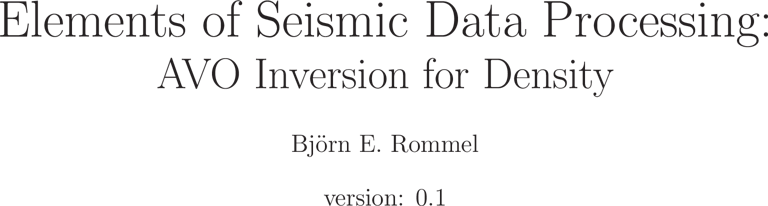

In [8]:
%steinkauz --option notebook --dpi $dpi --mag $mag --texdir title --texfile title VERSION

top medium:

In [9]:
vp1_box = ipw.BoundedFloatText(description="P-velocity", value=2000, min=0, step=1, max=sys.maxsize)
vs1_box = ipw.BoundedFloatText(description="S-velocity", value=1200, min=0, step=1, max=sys.maxsize)
rho1_box = ipw.BoundedFloatText(description="density", value=2000, min=0, step=1, max=sys.maxsize)

dvp1_box = ipw.BoundedFloatText(description="+/-", value=25, min=0, step=1, max=sys.maxsize)
dvs1_box = ipw.BoundedFloatText(description="+/-", value=15, min=0, step=1, max=sys.maxsize)
drho1_box = ipw.BoundedFloatText(description="+/-", value=20, min=0, step=1, max=sys.maxsize)
    
items = [vp1_box, vs1_box, rho1_box, dvp1_box, dvs1_box, drho1_box]
ipw.GridBox(items, layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))

GridBox(children=(BoundedFloatText(value=2000.0, description='P-velocity', max=9.223372036854776e+18, step=1.0…

bottom medium:

In [10]:
vp2_box = ipw.BoundedFloatText(description="P-velocity", value=2500, min=0, step=1, max=sys.maxsize)
vs2_box = ipw.BoundedFloatText(description="S-velocity", value=1500, min=0, step=1, max=sys.maxsize)
rho2_box = ipw.BoundedFloatText(description="density", value=2200, min=0, step=1, max=sys.maxsize)

dvp2_box = ipw.BoundedFloatText(description="+/-", value=25, min=0, step=1, max=sys.maxsize)
dvs2_box = ipw.BoundedFloatText(description="+/-", value=15, min=0, step=1, max=sys.maxsize)
drho2_box = ipw.BoundedFloatText(description="+/-", value=20, min=0, step=1, max=sys.maxsize)

items = [vp2_box, vs2_box, rho2_box, dvp2_box, dvs2_box, drho2_box]
ipw.GridBox(items, layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))

GridBox(children=(BoundedFloatText(value=2500.0, description='P-velocity', max=9.223372036854776e+18, step=1.0…

In [11]:
# prepare final pdf file
%steinkauz --option printout --texdir . --texfile avo_for_density

# WORK IN PROGRESS!!!

In [12]:
# clean
%steinkauz -o clean

In [13]:
# input toggle
%inputtoggle